In [1]:
import numpy as np
import pandas as pd
import mysql.connector
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
sns.set()
sns.set_context("talk", rc={"font.size":16,"axes.titlesize":24,"axes.labelsize":20})

In [2]:
server = mysql.connector.connect(user="apark2",
                                 password="Mindinmsight@1",
                                 host="127.0.0.1",
                                 database="widap")
# Seems to only want 1 connection at a time, for one user. Otherwise, Interface Error
query = server.cursor(buffered=True)

In [3]:
def getHRCdata(orispl, unit):
    query = "SELECT \
                gload, \
                heat_input, \
                CAST(gload as DECIMAL(8))*CAST(op_time as DECIMAL(8)) as gen, \
                (CAST(gload as DECIMAL(8))*CAST(op_time as DECIMAL(8)))/(CAST(heat_input as DECIMAL(8))*0.29307107) as efficiency \
            FROM \
                widap.data \
            WHERE ORISPL_CODE = " + str(orispl) + " AND UNITID = '" + str(unit) + "'"
    HRCdata = pd.read_sql(query, server).dropna(subset=['gload'])
    return HRCdata

In [4]:
data = getHRCdata(422, 'GT3')
data.head()
data.shape

(20308, 4)

In [5]:
def fitPredKDE(orispl, unit, nToEval=200, krnl='gaussian'):
    # Fits a Kernel Density Estimator model to the data retrieved for each power plant unit.
    # Returns a vector densities, evaluated at the given x points
    # nToEval = number of points to evaluate with KDE. Points will be linearly space from 0 to unit capacity.
    data = getHRCdata(orispl, str(unit))
    print(data.shape[0])
    if data.shape[0] == 0: # Return no data flag if 'data' is empty 
        return -1, str(-1), str(-1)
    gload = data[data['gload'] > 0.1]['gload'] # filter for when plants are ondata['gload'] # filter for 'on'
    gload = gload.values.reshape(-1, 1) # for sklearn w/single feature
    KDE = KernelDensity(kernel=krnl, bandwidth=1).fit(gload)  # bandwidth has large effect on smoothing
    capacity = gload.max()
    xToPlot = np.linspace(0, capacity, nToEval).reshape(-1, 1)  # newaxis = None, does same as reshape(-1, 1)
    logDensity = KDE.score_samples(xToPlot) # evaluate Gaussian kde on linearly space vector
#     print('Log-density: ', np.trapz(logDensity), 'does not integrate to 1')
    density = np.exp(logDensity)
#     print('exponentiated: ', np.trapz(density, dx=abs(xToPlot[0] - xToPlot[1])))
    return xToPlot, density, capacity

In [6]:
def getPmin_1dmax(x, density, ddx):
    # Use max positive 1st derivative to locate Pmin.
    # EDIT: A bad idea. Too conservative, not meaningful.
    
    idx = np.argmax(ddx[ddx>0]) 
    Pmin = round(x[idx, 0], 2)
#     print('Pmin (max 1st deriv): ', Pmin, 'MW')
    return Pmin, idx

In [7]:
def getPmin_2dmin(x, density, d2dx2):
    # Minimum d2(cdf)/dx2 = Point of maximum cdf concavity = Elbow
    idx = np.argmin(d2dx2)
    Pmin = round(x[idx, 0], 2)
    return Pmin, idx

In [8]:
def getPmin_2d0(x, density, d2dx2):
    # Use  d2(cdf)/dx2 = 0 to locate Pmin
    idx = np.argmax(abs(d2dx2))
    Pmin = round(x[idx, 0], 2)
#     print('Pmin (2nd deriv = 0): ', Pmin, 'MW')
    return Pmin, idx

In [9]:
def plotKDE_PDF_CDF_Pmin(orispl, unit, nToEval=200, krnl='gaussian'):
    # Fit kde to gload data
    x, density, capacity = fitPredKDE(orispl, unit)

    # Find Pmin
    d1_pdf = np.gradient(density)
    d2_pdf = np.gradient(d1_pdf)
    cumDensity = np.cumsum(density)
    cumDensity = cumDensity/np.max(cumDensity)  # normalize
    d1_cdf = np.gradient(cumDensity)
    Pmin_1d, Pmin_1d_idx = getPmin_2dmin(x, density, d1_pdf)
    Pmin_2d0, Pmin_2d0_idx = getPmin_2d0(x, density, d2_pdf)

    # Plot
    fig = plt.figure(figsize=(12, 14))
    ax1 = fig.add_subplot(211)
    ax1.plot(x[:, 0], density, label="kernel = {0}".format(krnl))
    ax1.plot(x[:, 0], d1_pdf, label="1st derivative")
    ax1.axvline(x=Pmin_1d, color='k', linestyle='--', label='Pmin (max 1st deriv)')
    ax1.axvline(x=Pmin_2d0, color='k', linestyle=':', label='Pmin (2nd deriv = 0)')
    ax1.annotate(str(Pmin_1d) + ' MW', xy=(Pmin_1d, density[Pmin_1d_idx]), xytext=(x[:, 0].max()*0.55, density.max()*0.6),
                arrowprops=dict(facecolor='black'), size=16, bbox=dict(boxstyle="round", fc="whitesmoke"))
    ax1.annotate(str(Pmin_2d0) + ' MW', xy=(Pmin_2d0, density[Pmin_2d0_idx]), xytext=(Pmin_2d0*0.5, density.max()*0.8),
                arrowprops=dict(facecolor='black'), size=16, bbox=dict(boxstyle="round", fc="whitesmoke"))
    ax1.set_xlim([0, 1.04*capacity])
    ax1.set_title('PDF', size=20)
    plt.legend()
    
    ax2 = fig.add_subplot(212, sharex=ax1)
    ax2.plot(x[:, 0], cumDensity, label="kernel = {0}".format(krnl))
    ax2.plot(x[:, 0], d1_cdf, label="1st derivative")
    ax2.axvline(x=Pmin_1d, color='k', linestyle='--', label='Pmin (max 1st deriv)')
    ax2.axvline(x=Pmin_2d0, color='k', linestyle=':', label='Pmin (2nd deriv = 0)')
    ax2.annotate(str(Pmin_1d) + ' MW', xy=(Pmin_1d, cumDensity[Pmin_1d_idx]), xytext=(0.5*Pmin_1d, 0.7),
                arrowprops=dict(facecolor='black'), size=16, bbox=dict(boxstyle="round", fc="whitesmoke"))
    ax2.annotate(str(Pmin_2d0) + ' MW', xy=(Pmin_2d0, cumDensity[Pmin_2d0_idx]), xytext=(0.5*Pmin_2d0, 0.4),
                arrowprops=dict(facecolor='black'), size=16, bbox=dict(boxstyle="round", fc="whitesmoke"))    
    ax2.set_xlabel('Power Output (MW)')
    ax2.set_ylabel('Fraction of data')
    ax2.set_title('CDF', size=20)
    
    plt.legend()
    plt.suptitle('Extracting Pmin from PDFs and CDFs: {0}_{1}'.format(orispl, unit), size=24)
    plt.savefig('PDF_CDF_KDE/Pmin/Pmin_{0}_{1}.png'.format(orispl, unit))
    plt.show()

20308


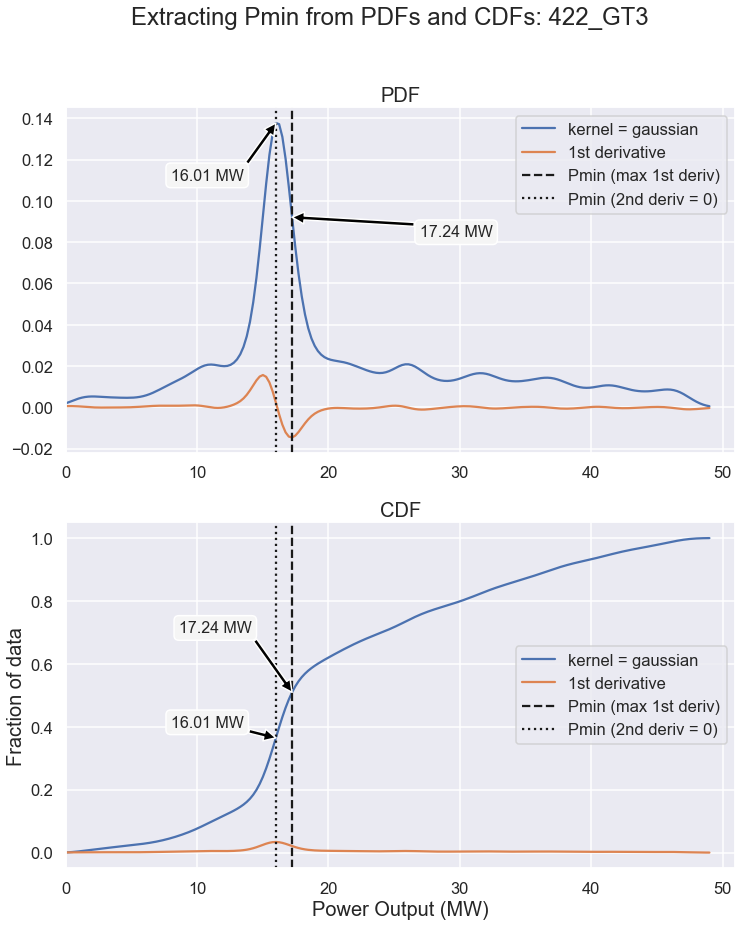

In [10]:
plotKDE_PDF_CDF_Pmin(422, 'GT3')

(array([ 491., 1043., 2350., 7968., 1447., 1604., 1384., 1214.,  863.,
         507.]),
 array([ 1. ,  5.8, 10.6, 15.4, 20.2, 25. , 29.8, 34.6, 39.4, 44.2, 49. ]),
 <a list of 10 Patch objects>)

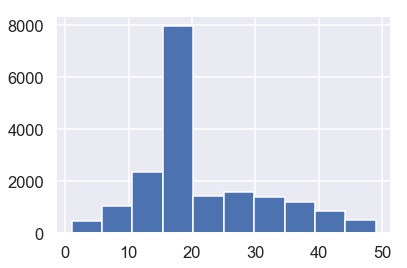

In [11]:
gload = data[data['gload'] > 0.1]['gload'] # filter for when plants are ondata['gload'] # filter for 'on'
gload = gload.values.reshape(-1, 1) # for sklearn w/single feature
plt.hist(gload)

73989


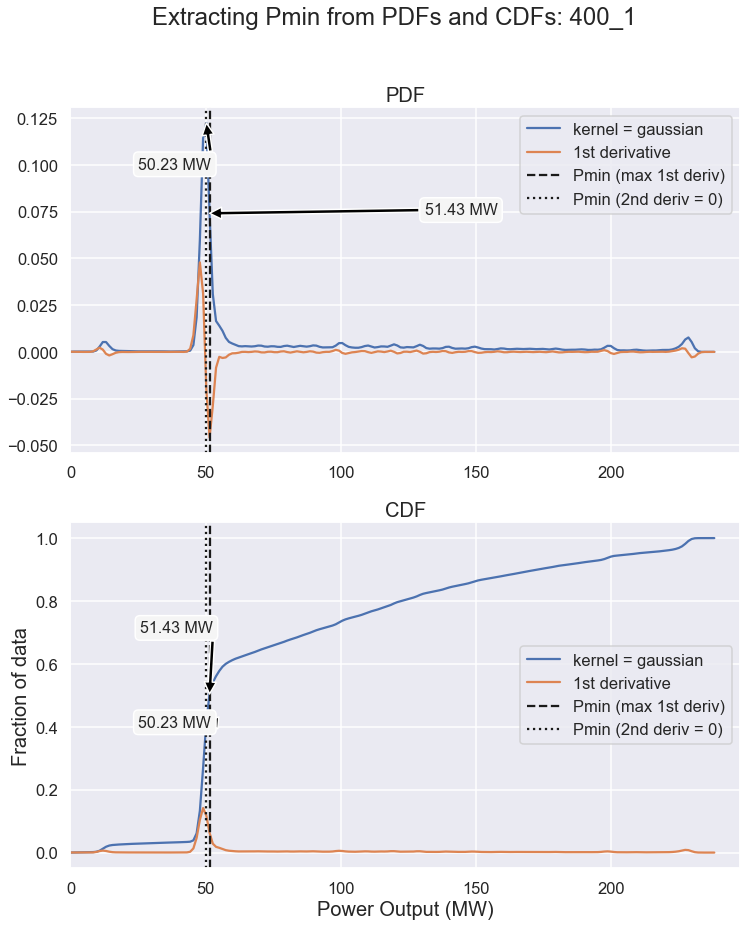

In [12]:
plotKDE_PDF_CDF_Pmin(400, '1')

136289


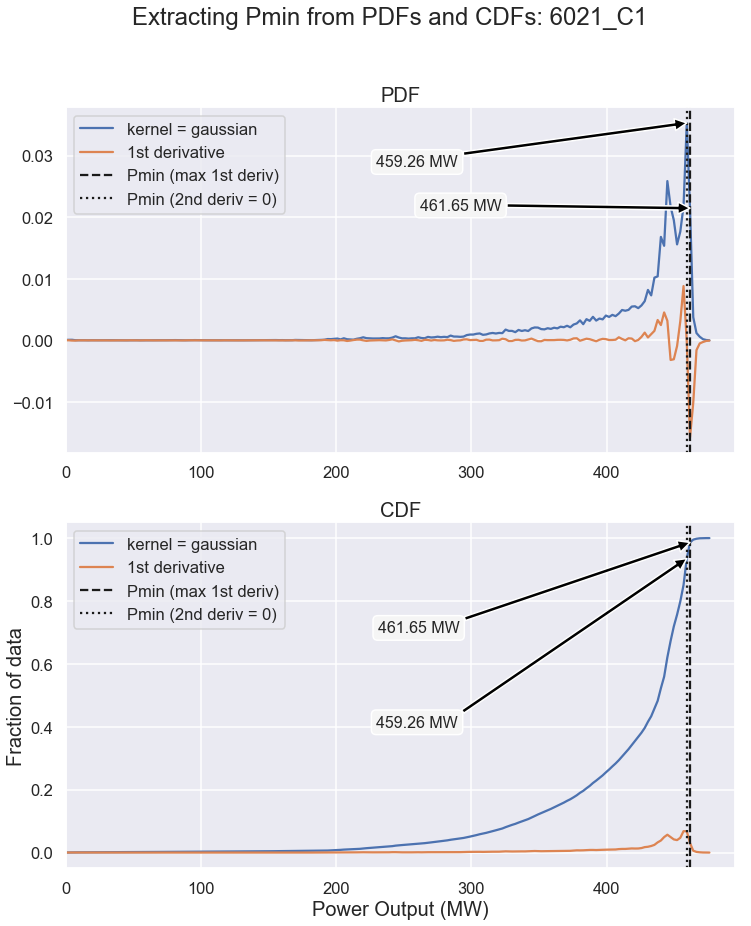

In [13]:
plotKDE_PDF_CDF_Pmin(6021, 'C1')

93767


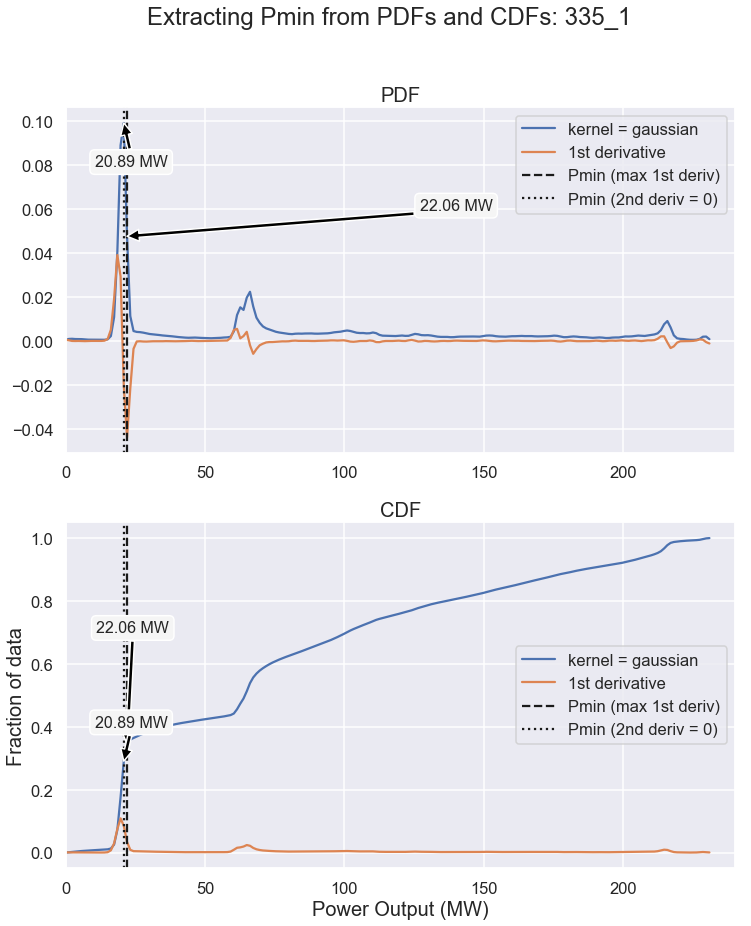

In [14]:
plotKDE_PDF_CDF_Pmin(335, '1')

126483


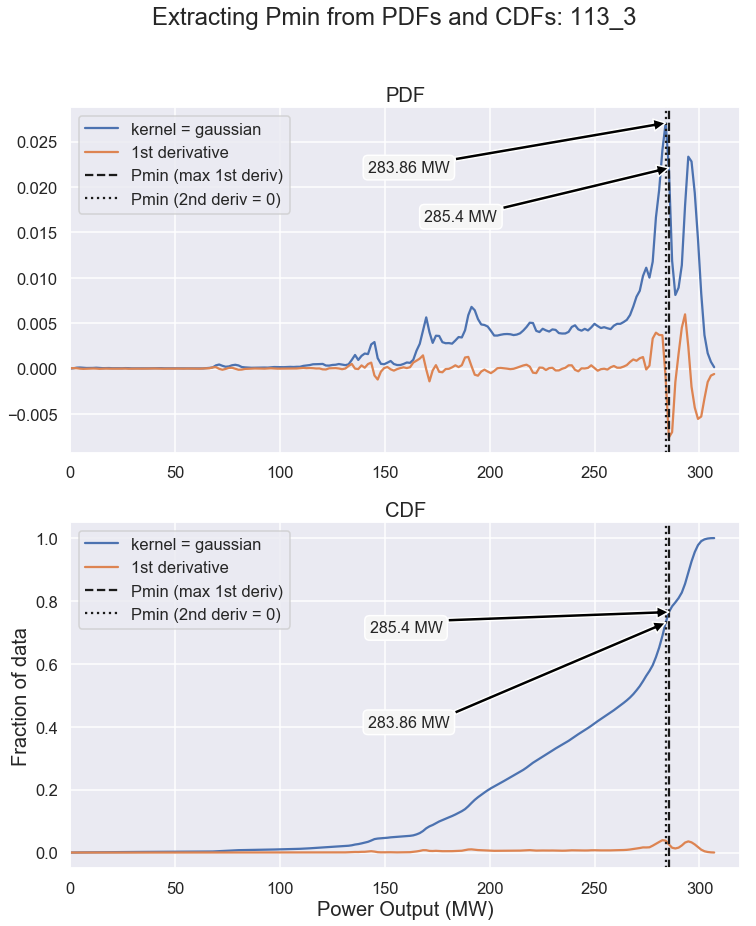

In [15]:
plotKDE_PDF_CDF_Pmin(113, '3')

78785


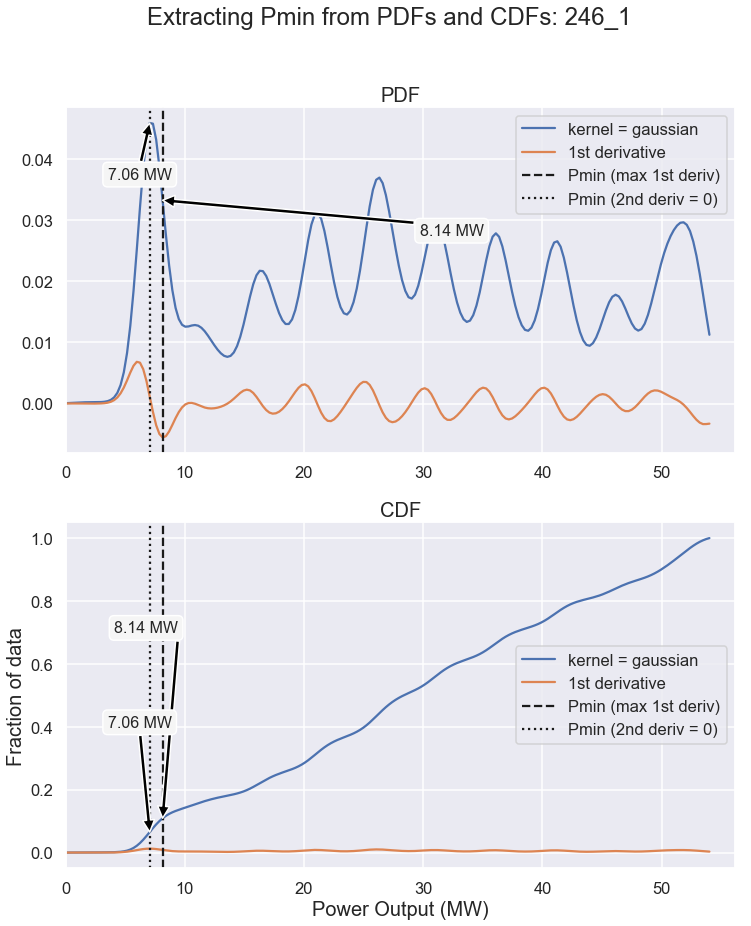

In [16]:
plotKDE_PDF_CDF_Pmin(246, '1')

2370


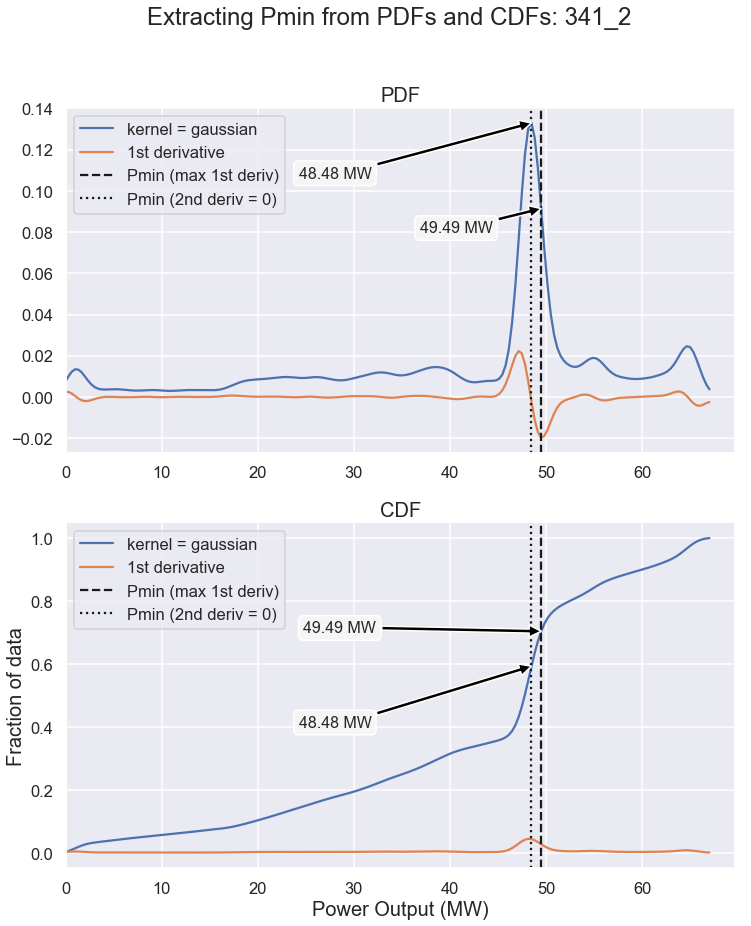

In [17]:
plotKDE_PDF_CDF_Pmin(341, '2')

Save Pmin for all plants

In [18]:
def savePmin(plantDF, nToEval=200, krnl='gaussian'):
    # This function extracts Pmin with both methods for each (plant, unit) row in the plant df passed, and saves the results in a csv
    # Pmin_1d = Pmin calculated by finding the maximum value for the 1st derivative of the KDE.
    # Pmin_2d0 = Pmin calculated by finding the value of the 2nd derivative of the KDE closest to 0.
    toSave = pd.DataFrame(index=range(plantDF.shape[0]), columns=['ORISPL_CODE', 'UNITID', 'NAME', 'Pmin_1d', 'Pmin_2d0', 'CAPACITY'])
    
    for i, plant in plantDF.iterrows():
        plantUnit = tuple((plant[0], plant[1]))
        print(plant[2], ': ', plantUnit)
        x, density, capacity = fitPredKDE(*plantUnit)
        if isinstance(x, int):  # no data flag
            Pmin_1d = -1
            Pmin_2d0 = -1
            capacity = -1
        else:
            # Find Pmin
            d1_pdf = np.gradient(density)
            d2_pdf = np.gradient(d1_pdf)
            cumDensity = np.cumsum(density)
            cumDensity = cumDensity/np.max(cumDensity)  # normalize
            d1_cdf = np.gradient(cumDensity)
            Pmin_1d, Pmin_1d_idx = getPmin_2dmin(x, density, d1_pdf)
            Pmin_2d0, Pmin_2d0_idx = getPmin_2d0(x, density, d2_pdf)
        nextRow = np.array([plant[0], plant[1], plant[2], Pmin_1d, Pmin_2d0, capacity])
        print(nextRow)
        toSave.iloc[i, :] = nextRow
    toSave.to_csv('Pmin.csv', index=False)
    return

Concatenate units list - need to cross-reference with Scott's list

In [250]:
NG_labels = pd.read_csv('C:/Users/apark2/Documents/Year 2/Research/Analysis/NG_labels_laptop.csv', index_col=0)
NG_labels['fuel'] = 'NG'
print(NG_labels.shape)
coal_labels = pd.read_csv('C:/Users/apark2/Documents/Year 2/Research/Analysis/coal_labels_laptop.csv', index_col=0)
coal_labels['fuel'] = 'coal'
print(coal_labels.shape)
WI_units = coal_labels.append(NG_labels)
print(WI_units.shape)
# save labels as csv
WI_units.to_csv('WI_units.csv', index=False)
# drop all other columns
print('before drop:', WI_units.head())
WI_units.drop(labels=['latitude', 'longitude', 'county', 'state', 'total_gen', 'capacity'], axis=1, inplace=True)
print('\n after:', WI_units.head())

(623, 10)
(102, 10)
(725, 10)
before drop:    orispl_code unitid        name  latitude  longitude    county state  \
0           87      1  Escalante    35.4159  -108.0820  McKinley    NM   
1          113      1      Cholla   34.9394  -110.3033    Navajo    AZ   
2          113      2      Cholla   34.9394  -110.3033    Navajo    AZ   
3          113      3      Cholla   34.9394  -110.3033    Navajo    AZ   
4          113      4      Cholla   34.9394  -110.3033    Navajo    AZ   

   total_gen  capacity  fuel  
0   27886837       273  coal  
1   13573545       132  coal  
2   29133162       306  coal  
3   30366954       307  coal  
4   46565885       436  coal  

 after:    orispl_code unitid        name  fuel
0           87      1  Escalante   coal
1          113      1      Cholla  coal
2          113      2      Cholla  coal
3          113      3      Cholla  coal
4          113      4      Cholla  coal


In [266]:
savePmin(WI_units, nToEval=200, krnl='gaussian')

Escalante  :  (87, '1')
136666
['87' '1' 'Escalante ' '241.45' '234.59' '273.0']
Cholla :  (113, '1')
128540
['113' '1' 'Cholla' '126.03' '119.4' '132.0']
Cholla :  (113, '2')
117961
['113' '2' 'Cholla' '299.85' '296.77' '306.0']
Cholla :  (113, '3')
126483
['113' '3' 'Cholla' '285.4' '283.86' '307.0']
Cholla :  (113, '4')
133358
['113' '4' 'Cholla' '381.23' '379.04' '436.0']
Irvington Generating Station :  (126, '4')
132194
['126' '4' 'Irvington Generating Station' '40.87' '40.04' '166.0']
Apache Station :  (160, '2')
136887
['160' '2' 'Apache Station' '196.28' '194.17' '210.0']
Apache Station :  (160, '3')
136364
['160' '3' 'Apache Station' '196.02' '194.95' '212.0']
Arapahoe :  (465, '1')
16405
['465' '1' 'Arapahoe' '41.79' '23.22' '44.0']
Arapahoe :  (465, '2')
12337
['465' '2' 'Arapahoe' '35.62' '33.83' '51.0']
Arapahoe :  (465, '3')
96189
['465' '3' 'Arapahoe' '43.72' '42.21' '50.0']
Arapahoe :  (465, '4')
92261
['465' '4' 'Arapahoe' '110.96' '108.51' '122.0']
Cameo :  (468, '2')

88518
['8223' 'TS3' 'Springerville Generating Station' '438.24' '433.63' '459.0']
North Valmy :  (8224, '1')
116075
['8224' '1' 'North Valmy' '260.3' '253.79' '1295.0']
North Valmy :  (8224, '2')
110285
['8224' '2' 'North Valmy' '295.03' '291.92' '309.0']
Sunnyside Cogeneration Associates :  (50951, '1')
17583
['50951' '1' 'Sunnyside Cogeneration Associates' '60.39' '59.16' '61.0']
Wygen I :  (55479, '1')
0
['55479' '1' 'Wygen I' '-1' '-1' '-1']
Hardin :  (55749, 'U1')
69429
['55749' 'U1' 'Hardin' '116.98' '115.78' '120.0']
TS Power Plant :  (56224, '1')
0
['56224' '1' 'TS Power Plant' '-1' '-1' '-1']
Wygen II :  (56319, '1')
0
['56319' '1' 'Wygen II' '-1' '-1' '-1']
Wygen III :  (56596, '1')
0
['56596' '1' 'Wygen III' '-1' '-1' '-1']
Dry Fork Station :  (56609, '1')
0
['56609' '1' 'Dry Fork Station' '-1' '-1' '-1']
Copper Station :  (9, 'CTG-1')
10814
['9' 'CTG-1' 'Copper Station' '45.73' '44.67' '70.0']
Ocotillo Power Plant :  (116, '1')
37125
['116' '1' 'Ocotillo Power Plant' '2.31'

['329' '41' 'Coolwater Generating Station' '44.42' '43.06' '136.0']
Coolwater Generating Station :  (329, '42')
28886
['329' '42' 'Coolwater Generating Station' '44.11' '42.11' '133.0']
El Segundo :  (330, '3')
38278
['330' '3' 'El Segundo' '76.38' '74.47' '380.0']
El Segundo :  (330, '4')
53746
['330' '4' 'El Segundo' '78.29' '76.38' '380.0']
El Segundo :  (330, '5')
16965
['330' '5' 'El Segundo' '263.19' '261.67' '301.0']
El Segundo :  (330, '7')
16614
['330' '7' 'El Segundo' '250.13' '158.55' '272.0']
Etiwanda Generating Station :  (331, '1')
3476
['331' '1' 'Etiwanda Generating Station' '39.14' '37.81' '132.0']
Etiwanda Generating Station :  (331, '2')
4690
['331' '2' 'Etiwanda Generating Station' '128.68' '127.36' '132.0']
Etiwanda Generating Station :  (331, '3')
43408
['331' '3' 'Etiwanda Generating Station' '32.56' '28.94' '360.0']
Etiwanda Generating Station :  (331, '4')
39083
['331' '4' 'Etiwanda Generating Station' '32.56' '30.84' '341.0']
Riverside Canal Power Company :  (

5194
['420' 'B2' 'Broadway' '12.1' '11.02' '43.0']
Broadway :  (420, 'B3')
41960
['420' 'B3' 'Broadway' '20.69' '19.27' '71.0']
Glenarm :  (422, 'GT3')
20308
['422' 'GT3' 'Glenarm' '17.24' '16.01' '49.0']
Glenarm :  (422, 'GT4')
17383
['422' 'GT4' 'Glenarm' '19.06' '18.09' '48.0']
Glenarm :  (422, 'GT5')
1841
['422' 'GT5' 'Glenarm' '22.12' '21.05' '71.0']
Cherokee :  (469, '5')
14966
['469' '5' 'Cherokee' '95.88' '94.28' '318.0']
Cherokee :  (469, '6')
16721
['469' '6' 'Cherokee' '97.48' '95.88' '318.0']
Zuni :  (478, '1')
23764
['478' '1' 'Zuni' '18.15' '14.48' '43.0']
Zuni :  (478, '2')
3598
['478' '2' 'Zuni' '27.66' '16.64' '43.0']
Zuni :  (478, '3')
3808
['478' '3' 'Zuni' '28.64' '1.13' '75.0']
Fredonia Generating Station :  (607, 'CT3')
7459
['607' 'CT3' 'Fredonia Generating Station' '54.21' '51.1' '62.0']
Fredonia Generating Station :  (607, 'CT4')
6952
['607' 'CT4' 'Fredonia Generating Station' '54.52' '51.1' '62.0']
Glendive Generating Station :  (2176, 'GT-2')
4754
['2176' 'GT

7061
['7315' '2' 'Almond Power Plant' '52.37' '50.74' '54.0']
Almond Power Plant :  (7315, '3')
10064
['7315' '3' 'Almond Power Plant' '52.24' '51.13' '55.0']
Almond Power Plant :  (7315, '4')
4376
['7315' '4' 'Almond Power Plant' '52.34' '35.18' '56.0']
Coyote Springs :  (7350, 'CTG1')
101022
['7350' 'CTG1' 'Coyote Springs' '207.29' '205.9' '275.0']
Coyote Springs :  (7350, 'CTG2')
83588
['7350' 'CTG2' 'Coyote Springs' '206.52' '204.96' '309.0']
NCPA Combustion Turbine Project #2 :  (7449, 'NA1')
17186
['7449' 'NA1' 'NCPA Combustion Turbine Project #2' '51.4' '50.07' '53.0']
Rathdrum Combustion Turbine Project :  (7456, '1')
9466
['7456' '1' 'Rathdrum Combustion Turbine Project' '81.53' '80.08' '96.0']
Rathdrum Combustion Turbine Project :  (7456, '2')
9305
['7456' '2' 'Rathdrum Combustion Turbine Project' '79.11' '77.74' '91.0']
Neil Simpson II :  (7504, 'CT1')
25735
['7504' 'CT1' 'Neil Simpson II' '40.0' '38.59' '40.0']
Carson Cogeneration :  (7527, '1')
139770
['7527' '1' 'Carson C

['55077' 'EDE2' 'Desert Star Energy Center' '166.6' '144.64' '257.0']
Klamath Cogeneration Project :  (55103, 'CT1')
95941
['55103' 'CT1' 'Klamath Cogeneration Project' '259.33' '158.17' '366.0']
Klamath Cogeneration Project :  (55103, 'CT2')
93674
['55103' 'CT2' 'Klamath Cogeneration Project' '257.91' '157.31' '364.0']
Calpine Sutter Energy Center :  (55112, 'CT01')
72640
['55112' 'CT01' 'Calpine Sutter Energy Center' '282.09' '271.13' '545.0']
Calpine Sutter Energy Center :  (55112, 'CT02')
72073
['55112' 'CT02' 'Calpine Sutter Energy Center' '282.93' '269.07' '552.0']
Griffith Energy LLC :  (55124, 'P1')
58934
['55124' 'P1' 'Griffith Energy LLC' '300.93' '298.85' '413.0']
Griffith Energy LLC :  (55124, 'P2')
62644
['55124' 'P2' 'Griffith Energy LLC' '295.54' '292.04' '348.0']
Manchief Generating Station :  (55127, 'CT1')
25907
['55127' 'CT1' 'Manchief Generating Station' '134.18' '107.01' '169.0']
Manchief Generating Station :  (55127, 'CT2')
26589
['55127' 'CT2' 'Manchief Generatin

89740
['55455' 'CC1A' 'Redhawk Generating Facility' '112.49' '111.05' '287.0']
Redhawk Generating Facility :  (55455, 'CC1B')
88441
['55455' 'CC1B' 'Redhawk Generating Facility' '112.49' '111.05' '287.0']
Redhawk Generating Facility :  (55455, 'CC2A')
87089
['55455' 'CC2A' 'Redhawk Generating Facility' '111.95' '110.53' '282.0']
Redhawk Generating Facility :  (55455, 'CC2B')
86229
['55455' 'CC2B' 'Redhawk Generating Facility' '111.16' '109.75' '280.0']
Neil Simpson II (CT2) :  (55477, 'CT2')
16419
['55477' 'CT2' 'Neil Simpson II (CT2)' '40.0' '39.6' '40.0']
Mesquite Generating Station :  (55481, '1')
92420
['55481' '1' 'Mesquite Generating Station' '264.82' '165.73' '340.0']
Mesquite Generating Station :  (55481, '2')
93057
['55481' '2' 'Mesquite Generating Station' '259.3' '162.49' '344.0']
Mesquite Generating Station :  (55481, '5')
101190
['55481' '5' 'Mesquite Generating Station' '258.69' '159.2' '330.0']
Mesquite Generating Station :  (55481, '6')
102203
['55481' '6' 'Mesquite Gen

80594
['55687' 'BHG2' 'Walter M. Higgins III Generating Station' '114.9' '111.8'
 '309.0']
Hanford Energy Park Peaker :  (55698, 'HEP1')
14761
['55698' 'HEP1' 'Hanford Energy Park Peaker' '47.16' '33.32' '51.0']
Hanford Energy Park Peaker :  (55698, 'HEP2')
14919
['55698' 'HEP2' 'Hanford Energy Park Peaker' '48.18' '33.32' '51.0']
Mint Farm Generating Station :  (55700, 'CTG1')
47874
['55700' 'CTG1' 'Mint Farm Generating Station' '197.79' '192.84' '328.0']
Bennett Mountain Power Project :  (55733, 'CT01')
7928
['55733' 'CT01' 'Bennett Mountain Power Project' '164.64' '161.61' '201.0']
Los Esteros Critical Energy Facility :  (55748, 'CTG1')
14031
['55748' 'CTG1' 'Los Esteros Critical Energy Facility' '48.84' '48.03'
 '81.0']
Los Esteros Critical Energy Facility :  (55748, 'CTG2')
14162
['55748' 'CTG2' 'Los Esteros Critical Energy Facility' '49.05' '47.84'
 '80.0']
Los Esteros Critical Energy Facility :  (55748, 'CTG3')
14567
['55748' 'CTG3' 'Los Esteros Critical Energy Facility' '48.8' 

16312
['56467' 'CT2' 'Russell City Energy Company LLC' '264.54' '283.9' '321.0']
McGrath Generating Station :  (56471, 'CT1')
4642
['56471' 'CT1' 'McGrath Generating Station' '51.0' '49.97' '51.0']
Grapeland Generating Station :  (56472, 'CT1')
5131
['56472' 'CT1' 'Grapeland Generating Station' '49.46' '47.67' '51.0']
Mira Loma Peaker :  (56473, 'CT1')
5263
['56473' 'CT1' 'Mira Loma Peaker' '49.72' '47.92' '51.0']
Barre Peaker :  (56474, 'CT1')
5906
['56474' 'CT1' 'Barre Peaker' '51.0' '49.72' '51.0']
Center Peaker :  (56475, 'CT1')
5500
['56475' 'CT1' 'Center Peaker' '50.74' '49.21' '51.0']
Gateway Generating Station :  (56476, 'GT1')
58451
['56476' 'GT1' 'Gateway Generating Station' '271.06' '269.5' '310.0']
Gateway Generating Station :  (56476, 'GT2')
58078
['56476' 'GT2' 'Gateway Generating Station' '272.17' '270.63' '306.0']
Black Mountain Generating Station :  (56482, '1')
10407
['56482' '1' 'Black Mountain Generating Station' '47.03' '45.8' '49.0']
Black Mountain Generating Stat

5326
['57483' 'GT-4' 'Mariposa Energy Project' '27.17' '25.88' '51.0']
Walnut Creek Energy Park :  (57515, 'GT1')
7702
['57515' 'GT1' 'Walnut Creek Energy Park' '102.16' '101.09' '107.0']
Walnut Creek Energy Park :  (57515, 'GT2')
6832
['57515' 'GT2' 'Walnut Creek Energy Park' '102.16' '100.55' '107.0']
Walnut Creek Energy Park :  (57515, 'GT3')
6848
['57515' 'GT3' 'Walnut Creek Energy Park' '101.62' '100.55' '107.0']
Walnut Creek Energy Park :  (57515, 'GT4')
6162
['57515' 'GT4' 'Walnut Creek Energy Park' '99.47' '98.4' '107.0']
Walnut Creek Energy Park :  (57515, 'GT5')
6297
['57515' 'GT5' 'Walnut Creek Energy Park' '100.55' '98.93' '107.0']
Pio Pico Energy Center LLC :  (57555, 'CTG1')
1383
['57555' 'CTG1' 'Pio Pico Energy Center LLC' '55.08' '53.94' '113.0']
Pio Pico Energy Center LLC :  (57555, 'CTG2')
1508
['57555' 'CTG2' 'Pio Pico Energy Center LLC' '54.9' '53.74' '115.0']
Pio Pico Energy Center LLC :  (57555, 'CTG3')
1501
['57555' 'CTG3' 'Pio Pico Energy Center LLC' '54.79' '53

### Also, I'd like to plot a colormap/2nd axis describing the % or count of hours <= 1, or some way to reflect where in the dispatch cycle we are 

### Compute bias-variance tradeoff to rigorously minimize error on the bandwidth parameter

73989


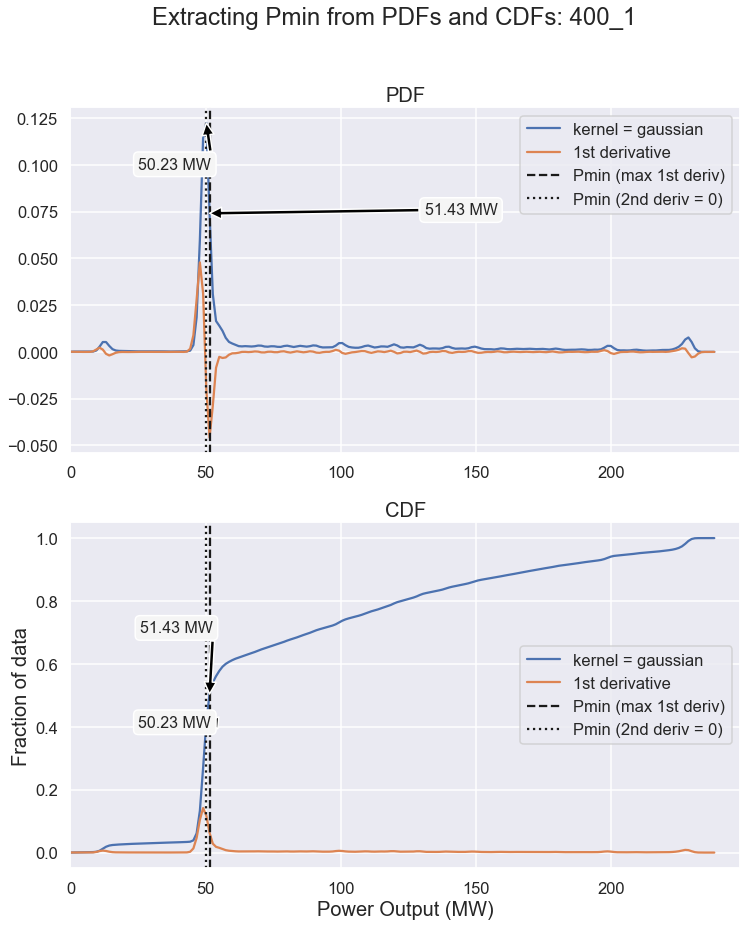

In [19]:
plotKDE_PDF_CDF_Pmin(400, '1')

In [20]:
def fitPredKDE(orispl, unit, nToEval=200, krnl='gaussian'):
    # Fits a Kernel Density Estimator model to the data retrieved for each power plant unit.
    # Returns a vector densities, evaluated at the given x points
    # nToEval = number of points to evaluate with KDE. Points will be linearly space from 0 to unit capacity.
    data = getHRCdata(orispl, str(unit))
    print(data.shape[0])
    if data.shape[0] == 0: # Return no data flag if 'data' is empty 
        return -1, str(-1), str(-1)
    gload = data[data['gload'] > 0.1]['gload'] # filter for when plants are ondata['gload'] # filter for 'on'
    gload = gload.values.reshape(-1, 1) # for sklearn w/single feature
    KDE = KernelDensity(kernel=krnl, bandwidth=1).fit(gload)  # bandwidth has large effect on smoothing
    capacity = gload.max()
    xToPlot = np.linspace(0, capacity, nToEval).reshape(-1, 1)  # newaxis = None, does same as reshape(-1, 1)
    logDensity = KDE.score_samples(xToPlot) # evaluate Gaussian kde on linearly space vector
    density = np.exp(logDensity)
    return xToPlot, density, capacity

In [21]:
data = getHRCdata(400, '1')
gload = data[data['gload'] > 0.1]['gload'] # filter for when plants are ondata['gload'] # filter for 'on'
print(gload.shape)
gload = gload.values.reshape(-1, 1) # for sklearn w/single feature
print(gload.shape)

(72876,)
(72876, 1)


In [22]:
krnl = 'gaussian'
KDE = KernelDensity(kernel=krnl, bandwidth=1).fit(gload)

In [30]:
band_rng30 = {'bandwidth': np.logspace(-1, 0.5, 30)}
rng_search30 = GridSearchCV(KernelDensity(), band_rng30, cv=5, n_jobs=-1)  # iid=False
rng_search30.fit(gload)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=KernelDensity(algorithm='auto', atol=0, bandwidth=1.0, breadth_first=True,
       kernel='gaussian', leaf_size=40, metric='euclidean',
       metric_params=None, rtol=0),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'bandwidth': array([0.1    , 0.11265, 0.1269 , 0.14295, 0.16103, 0.18139, 0.20434,
       0.23018, 0.25929, 0.29209, 0.32903, 0.37065, 0.41753, 0.47034,
       0.52983, 0.59685, 0.67234, 0.75737, 0.85317, 0.96108, 1.08264,
       1.21957, 1.37382, 1.54759, 1.74333, 1.96383, 2.21222, 2.49202,
       2.80722, 3.16228])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [41]:
np.isnan(gload).any()

False

In [39]:
np.count_nonzero(np.isnan(gload))

0

In [46]:
print("best bandwidth: {0}".format(rng_search30.best_estimator_.bandwidth))

best bandwidth: 0.1


In [40]:
results = pd.DataFrame.from_dict(rng_search30.cv_results_)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bandwidth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.568913,0.083771,47.413431,25.903942,0.1,{'bandwidth': 0.1},-64757.256964,-42642.084420,-36973.868814,-31615.007658,...,-41710.039068,12166.562225,1,-137404.067381,-150214.930737,-155054.879573,-160757.631352,-159949.053514,-152676.112511,8522.416659
1,0.619693,0.227671,43.269714,23.436149,0.112648,{'bandwidth': 0.11264816923358861},-65274.513444,-44377.955682,-38709.740076,-33350.878920,...,-43202.173996,11705.894280,2,-144347.552429,-157158.534884,-161998.483720,-167701.235499,-166892.657661,-159619.692838,8522.459343
2,0.516526,0.137547,55.089133,22.867345,0.126896,{'bandwidth': 0.12689610031679222},-66050.085102,-46113.826944,-40445.611338,-35086.750182,...,-44745.974795,11344.453540,3,-151291.037477,-164102.139031,-168942.087867,-174644.839646,-173836.261808,-166563.273165,8522.502028
3,0.477347,0.174942,39.485362,10.709629,0.142946,{'bandwidth': 0.14294613383568447},-67029.221075,-47849.698205,-42181.482599,-36822.621443,...,-46330.490692,11060.708424,4,-158234.522522,-171045.743175,-175885.692011,-181588.443790,-180779.865952,-173506.853490,8522.544713
4,0.526916,0.223821,55.606718,9.258250,0.161026,{'bandwidth': 0.16102620275609392},-68168.775023,-49585.569347,-43917.353742,-38558.492569,...,-47947.091843,10837.836216,5,-165178.007080,-177989.346832,-182829.295669,-188532.047448,-187723.469609,-180450.433327,8522.587398
5,0.534959,0.161469,100.641903,36.052229,0.181393,{'bandwidth': 0.18139306939110622},-69434.738504,-51321.433542,-45653.217995,-40294.355809,...,-49588.970407,10662.689547,6,-172121.463303,-184932.922156,-189772.870991,-195475.622770,-194667.044932,-187393.984830,8522.630083
6,0.590065,0.212646,111.216210,44.475454,0.204336,{'bandwidth': 0.20433597178569418},-70800.148797,-53057.131958,-47388.917826,-42030.030850,...,-51250.599051,10524.989800,7,-179064.243326,-191875.821290,-196715.770088,-202418.521873,-201609.944060,-194336.860127,8522.672764
7,0.508919,0.155287,61.199749,19.423896,0.230181,{'bandwidth': 0.23018073130224664},-72242.027148,-54790.904828,-49122.707883,-43763.519998,...,-52925.891714,10416.722379,8,-185999.169252,-198810.866459,-203650.814817,-209353.566695,-208544.989168,-201271.881278,8522.715400
8,0.523103,0.209752,97.410099,23.122349,0.259294,{'bandwidth': 0.2592943797404667},-73732.587227,-56512.224681,-50844.147091,-45482.874993,...,-54600.377851,10331.777534,9,-192883.302977,-205695.120138,-210535.065465,-216237.818900,-215429.243007,-208156.110097,8522.757970
9,0.510510,0.192300,87.784532,26.884995,0.29209,{'bandwidth': 0.2920903717032248},-75219.163523,-58183.714176,-52516.168312,-47145.725840,...,-56231.899186,10265.898077,10,-199564.241217,-212376.178179,-217216.110529,-222918.889900,-222110.313871,-214837.146739,8522.804828


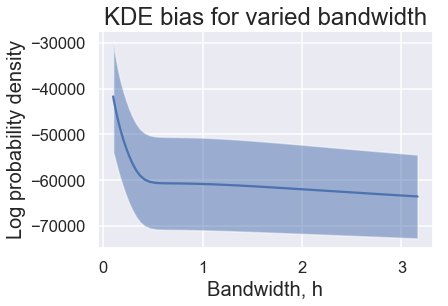

In [47]:
x = band_rng30['bandwidth']
y = results['mean_test_score']
yerr = results['std_test_score']
fig = plt.figure()
plt.plot(x, y)
plt.fill_between(x, y-yerr, y+yerr, alpha=0.5)
plt.xlabel('Bandwidth, h')
plt.ylabel('Log probability density')
plt.title('KDE bias for varied bandwidth')
plt.show()


In [12]:
np.logspace(-1, 0.5, 30)

array([0.1       , 0.11264817, 0.1268961 , 0.14294613, 0.1610262 ,
       0.18139307, 0.20433597, 0.23018073, 0.25929438, 0.29209037,
       0.32903446, 0.37065129, 0.41753189, 0.47034203, 0.52983169,
       0.5968457 , 0.67233575, 0.75737392, 0.85316785, 0.96107797,
       1.08263673, 1.21957046, 1.3738238 , 1.54758735, 1.74332882,
       1.963828  , 2.21221629, 2.49202115, 2.8072162 , 3.16227766])

In [16]:
np.logspace(-1, 0.5, 1)

array([0.1])

# Can also estimate max up + down ramps + minimum uptime + minimum downtime

In [2]:
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
digits = load_digits()

In [3]:
digits.data.shape

(1797, 64)

In [ ]:
# # project the 64-dimensional data to a lower dimension
# pca = PCA(n_components=2, whiten=False)
# data = pca.fit_transform(digits.data)

In [29]:
load_ext timeit
% timeit
print(14.)

SyntaxError: invalid syntax (<ipython-input-29-792e561206e6>, line 1)